# This file is made to generate a daily level trading strategy, and obtain related metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = '../Data/Parameter_tuning_0.9997/504_Prediction/SSA-CNN/'
def read_stock(file_name, directory):
    stock = pd.read_csv(directory + file_name, header = [0])
    index = pd.to_datetime(stock['Date'])
    stock = stock.drop('Date', axis = 1)
    stock.index = index
    return stock

def read_csv_files(directory):
    csv_files = []
    csv_files_path = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv') and not file.startswith('MAE'):
                csv_files.append(os.path.join(file))
                csv_files_path.append(os.path.join(root, file))

    All_stock = []
    for csv_file_path in csv_files_path:
        stock = read_stock(csv_file_path, '') 
        All_stock.append(stock)

    return csv_files, All_stock

files_name, All_stocks = read_csv_files(path)

In [3]:
# The stock's first column is actual, and thrid column is predict
len(All_stocks)
All_stocks[0].iloc[:, 2]

Date
2018-04-19    23.094040
2018-04-20    23.376605
2018-04-23    23.788576
2018-04-24    24.253593
2018-04-26    24.715291
                ...    
2023-03-27    36.804249
2023-03-28    36.950949
2023-03-29    36.958972
2023-03-30    37.015271
2023-03-31    37.125941
Name: Predict, Length: 1255, dtype: float64

In [4]:
Prediction_Result = pd.DataFrame()
for i in range(len(All_stocks)):
    stock_name = files_name[i][:-4]
    stock_value = All_stocks[i].iloc[-252:, 2]
    Prediction_Result[stock_name] = stock_value

Actual_Result = pd.DataFrame()
for i in range(len(All_stocks)):
    stock_name = files_name[i][:-4]
    stock_value = All_stocks[i].iloc[-252:, 0]
    Actual_Result[stock_name] = stock_value

Start_Date_Result = pd.DataFrame()
for i in range(len(All_stocks)):
    stock_name = files_name[i][:-4]
    stock_value = All_stocks[i].iloc[-253:-252, 0]
    Start_Date_Result[stock_name] = stock_value

## All daily predicted and actual return generation

In [5]:
date_index = Prediction_Result.index
Predicted_Percentage_Return = pd.DataFrame()
Actual_Percentage_Return = pd.DataFrame()

In [6]:
Predicted_Percentage_Return[date_index[0]] = (Prediction_Result.iloc[0,:] - Start_Date_Result.iloc[0, :]) / Start_Date_Result.iloc[0, :]
Actual_Percentage_Return[date_index[0]] = (Actual_Result.iloc[0,:] - Start_Date_Result.iloc[0, :]) / Start_Date_Result.iloc[0, :]

In [7]:
for i in range(1, 252):
    Predicted_Percentage_Return[date_index[i]] = (Prediction_Result.iloc[i,:] - Actual_Result.iloc[i - 1,:]) / Actual_Result.iloc[i - 1,:]
    Actual_Percentage_Return[date_index[i]] = (Actual_Result.iloc[i,:] - Actual_Result.iloc[i - 1,:]) / Actual_Result.iloc[i - 1,:]

Predicted_Percentage_Return = Predicted_Percentage_Return.T
Actual_Percentage_Return = Actual_Percentage_Return.T

# Buy the stock everyday with highest percentage daily return based on actual and prediction spread

In [8]:
Position = pd.DataFrame(0, index = date_index, columns = Prediction_Result.columns)

In [9]:
# Label the five largest daily percentage return to be 1
for i in range(252):
    five_largest = Predicted_Percentage_Return.iloc[i].nlargest(3)
    five_largest = five_largest[five_largest > 0]
    five_largest = five_largest.index
    Position.loc[date_index[i], five_largest] = 1

In [10]:
Initial_Position = 5000000
Final_Position = Initial_Position
commision_fee = 0.05*0.01
daily_return = pd.DataFrame(0, index = date_index, columns = ['return', 'Win Rate', 'Lose Rate', 'Dollar Gain', 'Dollar Loss'])
# Put 40% to trade everyday
for i in range(252):
    product = Position.iloc[i, :] * Actual_Percentage_Return.iloc[i, :]
    profit_or_lost = Initial_Position * 0.4 * np.sum(product) - commision_fee * Initial_Position * 0.4
    win = product[product > 0].count() / 3
    lose = 1 - win
    gain = np.sum(product[product > 0]) * Initial_Position * 0.4
    loss = np.sum(product[product < 0]) * Initial_Position * 0.4
    print(profit_or_lost)

    daily_return.iloc[i, 0] = profit_or_lost
    daily_return.iloc[i, 1] = win
    daily_return.iloc[i, 2] = lose
    daily_return.iloc[i, 3] = gain
    daily_return.iloc[i, 4] = loss

    Final_Position = Final_Position + profit_or_lost

-6415.300421469142
15606.688887179644
86497.96001809982
-6376.312995005158
21116.438308874498
43085.507027667256
-15366.197135695726
-183065.92021935523
7478.531428615592
34485.51562910973
-35008.71342141183
82715.25521414127
-50021.31370880737
-108932.93163187742
-186007.06643281147
-27060.936507064373
64307.04335763937
-51439.443899644095
-208760.0511749196
-46493.09545911462
-8079.606841826756
204129.35939363003
-318042.07795090915
-235977.48963606154
-25495.80154140412
63083.9978940083
-93349.66280156483
294320.45034734794
153908.63983534387
135100.03212472255
170556.11394484362
-139717.91343919313
164886.56921928367
-19804.33766236489
-1892.9005327617951
-127016.04445956655
25473.70405402122
29089.322341161376
127223.27561269986
11098.439584224565
95782.84165333897
-19385.79607039234
157694.6530239911
-52894.49853732752
-15125.506382330295
17780.870047573793
-125723.67812018476
-94694.22078948485
-163352.44142918536
-89207.08536602043
-39161.02655057103
-39489.06099957371
65899.42

In [11]:
monthly_result = daily_return.copy()
monthly_result['Date'] = monthly_result.index
monthly_result = monthly_result.groupby(monthly_result['Date'].dt.to_period('M')).agg({
    'return': 'sum',
    'Win Rate': 'mean',
    'Lose Rate': 'mean',
    'Dollar Gain': 'sum',
    'Dollar Loss': 'sum'
}).reset_index()
monthly_result['Date'] = monthly_result['Date'].dt.to_timestamp()
monthly_result.index = monthly_result['Date']
monthly_result = monthly_result.drop('Date', axis = 1)

In [12]:
yearly_result = pd.DataFrame(0, index = ['traing strategy performance'], columns = ['return', 'Win Rate', 'Lose Rate', 'Dollar Gain', 'Dollar Loss'])
yearly_result.iloc[0, 0] = np.sum(daily_return['return'].values)
yearly_result.iloc[0, 1] = np.mean(daily_return['Win Rate'].values)
yearly_result.iloc[0, 2] = np.mean(daily_return['Lose Rate'].values)
yearly_result.iloc[0, 3] = np.sum(daily_return['Dollar Gain'].values)
yearly_result.iloc[0, 4] = np.sum(daily_return['Dollar Loss'].values)

## Here are some functions to calculate the matrices

In [13]:
def calculate_roi(final_position, initial_investment):
    roi = final_position / initial_investment - 1
    return roi

def calculate_max_drawdown(daily_returns, initial_investment):
    daily = daily_returns.copy()
    cumulative_returns = daily.cumsum() + initial_investment
    peak_value = cumulative_returns.cummax()
    trough_value = cumulative_returns.cummin()
    max_drawdown = (trough_value - peak_value) / peak_value
    return max_drawdown.min()

def calculate_sharpe_ratio(daily_returns, initial_investment, risk_free_rate=0.02):
    portfolio_return = daily_returns.cumsum().iloc[-1]/initial_investment
    portfolio_std_dev = (daily_returns/initial_investment).std() * np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return sharpe_ratio

In [14]:
roi = calculate_roi(Final_Position, Initial_Position)
mmd = calculate_max_drawdown(daily_return['return'], Initial_Position)
sharpe = calculate_sharpe_ratio(daily_return['return'], Initial_Position)

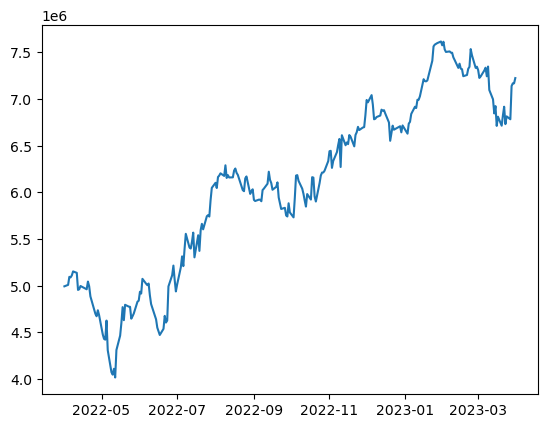

In [15]:
daily = daily_return['return'].copy()
cumulative_returns = daily.cumsum() + Initial_Position
plt.plot(cumulative_returns)
plt.show()

In [16]:
yearly_result['ROI'] = roi
yearly_result['Sharpe Ratio (rf = 0.2)'] = sharpe
yearly_result['Max DrawDown'] = mmd

In [17]:
daily_return.to_csv('../Trading Strategy/Results/SSA-CNN/504/Daily_Return_2.csv')
monthly_result.to_csv('../Trading Strategy/Results/SSA-CNN/504/Monthly_Return_2.csv')
yearly_result.to_csv('../Trading Strategy/Results/SSA-CNN/504/Test Set Metric_2.csv')
Position.to_csv('../Trading Strategy/Results/SSA-CNN/504/Position_2.csv')